In [109]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import sys

import funcs

### Testing mainIntegrand function

I'm running into problems, despite my code _looking_ like it works fine, so let me test each function individually, and carefully look at each line of code... 

k: -5.0
K(kS) = [nan nan nan nan nan nan nan nan nan nan]

k: -4.0
K(kS) = [nan nan nan nan nan nan nan nan nan nan]

k: -3.0
K(kS) = [nan nan nan nan nan nan nan nan nan nan]

k: -2.0
K(kS) = [nan nan nan nan nan nan nan nan nan nan]

k: -1.0
K(kS) = [nan nan nan nan nan nan nan nan nan nan]

k: 1.0
K(kS) = [0.49430767 0.58181517 0.73338672 0.66695541 0.51571822 0.51571822
 0.66695541 0.73338672 0.58181517 0.49430767]

k: 2.0
K(kS) = [0.10277758 0.13269667 0.18915188 0.16376248 0.10989033 0.10989033
 0.16376248 0.18915188 0.13269667 0.10277758]

k: 3.0
K(kS) = [0.02629304 0.03736563 0.0605504  0.04979635 0.02883552 0.02883552
 0.04979635 0.0605504  0.03736563 0.02629304]

k: 4.0
K(kS) = [0.00727212 0.01138948 0.02102298 0.0164093  0.00818295 0.00818295
 0.0164093  0.02102298 0.01138948 0.00727212]

k: 5.0
K(kS) = [0.00209471 0.00361774 0.00761355 0.00563796 0.0024188  0.0024188
 0.00563796 0.00761355 0.00361774 0.00209471]



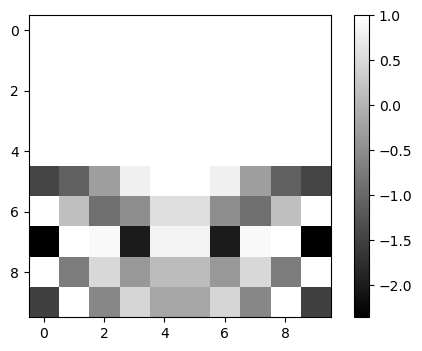

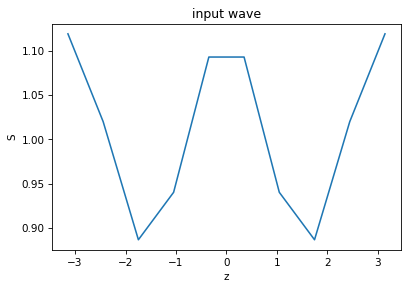

In [113]:
# the function returning the integrand eqs for the nondimensional eq. (3.4)
def mainIntegrand(S, c, z, N, L, b, B, epsilon):

    # define S derivatives (spectral)
    S_z = funcs.fftDeriv(S, z, order=1)
    S_zz = funcs.fftDeriv(S, z, order=2)

    # bessel functions 
    def I(domain, order=1):
        # modified bessel of first kind
        return sp.iv(order, domain)
    
    def K(domain, order=1):
        # modified bessel of second kind
        return sp.kn(order, domain)


    integrand = np.empty((N,len(z))) # initialize array of N integrand equations

    Szsq = 1 + (S_z**2) # commonly used value in eqs

    # get k values (N + 1 values but we discard the eq'n with k=0 in the for loop) 
    k_values = np.arange(-N/2, N/2 + 1, 1)*(np.pi/L)
#     k_values = np.arange(0, N + 1, 1)*(np.pi/L) # (only positive k values)
    i = 0

    for k in k_values:

        if k == 0.0:
            continue # we don't want to include the equation with k = 0 (trivial solution)

        print(f"k: {k}")
        
        # individual terms
        one_p = (Szsq)*((c**2)/2 - 1/(S*np.sqrt(Szsq)) + S_zz/(Szsq**(3/2)) + B/(2*(S**2)) + epsilon)
        one = k*S*np.sqrt(one_p)
        two = K(k*b)*I(k*S) - I(k*b)*K(k*S)
        three = np.cos(k*z)
        print(f"K(kS) = {K(k*S)}\n")

        # add eq'n to integrand array (each row is one eq'n) 
        integrand[i,:] = one*two*three
#         print(f"{np.min(integrand[i,:])}, {np.max(integrand[i,:])}")
        
        # divide integrand by max over one period to maintain well scaled Jacobian
        integrand[i,:] = integrand[i,:] / np.max(integrand[i,:])
#         integrand[i,:] = integrand[i,:] / np.max(np.abs(integrand[i,:])) # can also do this so integrand e (-1,1)
        i += 1

    return integrand

# now define each part and run the function
N = 10
c = 1.079
L = np.pi 

z = np.linspace(-L, L, N) # N points (used for now because I'm not zero padding)

B = 1.5
b = 0.1

epsilon = 1 - B/2

S = np.zeros(N)
S[0:3] = np.array([1.0, 1e-3, 0.12])
S = funcs.fourierToReal(S, z)

integrand_array = mainIntegrand(S, c, z, N, L, b, B, epsilon)
        
# plot integrand array
plt.figure(dpi=100)
plt.imshow(integrand_array, cmap='gray')
plt.colorbar()
plt.show()

# plot input profile
plt.figure(dpi=75)
plt.plot(z, S, '-')
plt.xlabel('z')
plt.ylabel('S')
plt.title('input wave')
plt.show()

# note: the first half rows of the integrand array seem to be filled exclusively with nans..
# (so the ones with the negative k values) — not necessarily the reason though 

# to do: check the equations again (typos), think of more possible solutions/things to check, 
# try computing solutons for only positive k values 


The problem appears to be with the modified bessel functions of the second kind (integer order) represented by K. Our equations include values of k which are negative (note that S is always positive), however the bessel function of second kind diverges as x $\rightarrow$ 0, and is not defined for negative values. So, we end up with **nan** values in the first half of our array of integrand equations (which are defined over the whole domain z), for negative k values from the "two" term in the equation. 

In [114]:
print(integrand_array)

[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [-1.44323622 -1.08855738 -0.27198664  0.79529266  1.          1.
   0.79529266 -0.27198664 -1.08855738 -1.44323622]
 [ 1.          0.1603562  -0.88349481 -0.49236329  0.55514347  0.55514347
  -0.49236329 -0.88349481  0.1603562   1.        ]
 [-2.35691226  1.          0.91360621 -1.99719245  0.83490795  0.83490795
  -1.99719245  0.91360621  1.         -2.35691226]
 [ 1.   

now observe what the integrals look like for the above N equations over the domain:

In [117]:
# initialze array for integrals
equations = np.empty(N)

# compute all integrals
for n in range(0, N):
    equations[n] = np.trapz(integrand_array[n,:], z)

print(f"Integration results: \n \n {equations}")

Integration results: 
 
 [        nan         nan         nan         nan         nan -0.40054533
 -0.22390261 -0.59639216  0.01912622 -0.0805527 ]


Potential solution is to use only positive k values, such that the $K_1$ bessel function is properly defined for all the inputs. While fsolve appears to make progress with such an arrangement, the solutions eventually reach a point whereby there appear negatives under the sqrt of the "one" equation and we end up **nans** over the whole domain again. (can print the "equations" array, which shows the integration results, in the main file to see this happen)